

## Vehicle Driver Drowsiness Detection with Deep Learning on Neural Networks

In [4]:


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import cv2
import pathlib


In [5]:
#load driver face image dataset

from google.colab import drive
drive.mount('/content/drive')
labels = os.listdir("/content/drive/My Drive/Colab Notebooks/sleep/train/")
dataset = pd.read_csv('/content/drive/My Drive/Colab Notebooks/sleep/Vehicle_Steering.csv',encoding='ISO-8859-1')




Mounted at /content/drive


# labels

In [ ]:
labels

['Closed', 'Open', 'no_yawn', 'yawn']

# visualize random 1 image

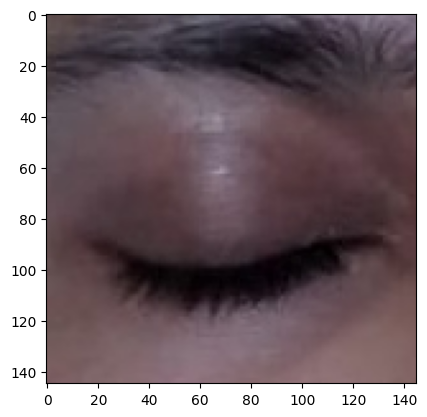

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(plt.imread("/content/drive/My Drive/Colab Notebooks/sleep/train/Closed/_0.jpg"))

# image array

In [ ]:
a = plt.imread("/content/drive/My Drive/Colab Notebooks/sleep/train/yawn/10.jpg")

# image shape

In [ ]:
a.shape

(480, 640, 3)

# visualize yawn image.
# Here background is unnecessary.need only face image array

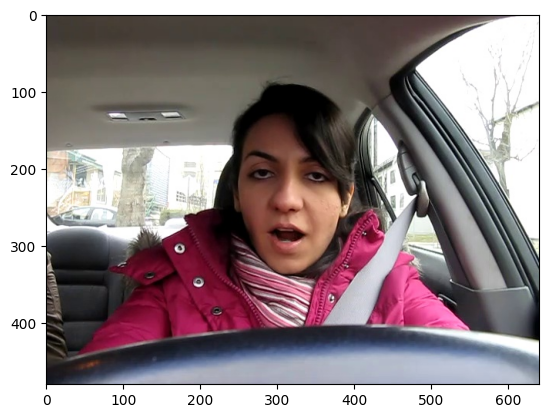

In [ ]:
plt.imshow(plt.imread("/content/drive/My Drive/Colab Notebooks/sleep/train/yawn/10.jpg"))

# for yawn and not_yawn. Take only face

In [ ]:
def face_for_yawn(direc="/content/drive/My Drive/Colab Notebooks/sleep/train",
                  face_cas_path="/content/drive/My Drive/Colab Notebooks/sleep/prediction-images/haarcascade_frontalface_default.xml"):
    yaw_no = []
    IMG_SIZE = 145
    categories = ["yawn", "no_yawn"]
    for category in categories:
        path_link = os.path.join(direc, category)
        class_num1 = categories.index(category)
        print(class_num1)
        for image in os.listdir(path_link):
            image_array = cv2.imread(os.path.join(path_link, image), cv2.IMREAD_COLOR)
            face_cascade = cv2.CascadeClassifier(face_cas_path)
            faces = face_cascade.detectMultiScale(image_array, 1.3, 5)
            for (x, y, w, h) in faces:
                img = cv2.rectangle(image_array, (x, y), (x+w, y+h), (0, 255, 0), 2)
                roi_color = img[y:y+h, x:x+w]
                resized_array = cv2.resize(roi_color, (IMG_SIZE, IMG_SIZE))
                yaw_no.append([resized_array, class_num1])
    return yaw_no


yawn_no_yawn = face_for_yawn()

0
1


# for closed and open eye

In [ ]:
def get_data(dir_path="/content/drive/My Drive/Colab Notebooks/sleep/train/",
             face_cas="/content/drive/My Drive/Colab Notebooks/sleep/prediction-images/haarcascade_frontalface_default.xml",
             eye_cas="/content/drive/My Drive/Colab Notebooks/sleep/prediction-images//haarcascade.xml"):
    labels = ['Closed', 'Open']
    IMG_SIZE = 145
    data = []
    for label in labels:
        path = os.path.join(dir_path, label)
        class_num = labels.index(label)
        class_num +=2
        print(class_num)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
                resized_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                data.append([resized_array, class_num])
            except Exception as e:
                print(e)
    return data

In [ ]:
data_train = get_data()

2
3


# extend data and convert array

In [ ]:
def append_data():
#     total_data = []
    yaw_no = face_for_yawn()
    data = get_data()
    yaw_no.extend(data)
    return np.array(yaw_no)

# new variable to store

In [ ]:
new_data = append_data()

0
1
2
3


<ipython-input-11-be15ac3ad549>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(yaw_no)


# separate label and features

In [ ]:
X = []
y = []
for feature, label in new_data:
    X.append(feature)
    y.append(label)

# reshape the array

In [ ]:
X = np.array(X)
X = X.reshape(-1, 145, 145, 3)

# LabelBinarizer

In [ ]:
from sklearn.preprocessing import LabelBinarizer
label_bin = LabelBinarizer()
y = label_bin.fit_transform(y)

# label array

In [ ]:
y = np.array(y)

# train test split

In [ ]:
from sklearn.model_selection import train_test_split
seed = 42
test_size = 0.30
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, test_size=test_size)

# length of X_test

In [ ]:
len(X_test)

4

# Not necessary, only use to matching with my pc version

In [ ]:
# !pip install tensorflow==2.3.1
# !pip install keras==2.4.3

# import some dependencies

In [ ]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

# tensorflow version

In [ ]:
tf.__version__

'2.15.0'

# keras version

In [ ]:
import keras
keras.__version__

'2.15.0'

# Data Augmentation

In [ ]:
train_generator = ImageDataGenerator(rescale=1/255, zoom_range=0.2, horizontal_flip=True, rotation_range=30)
test_generator = ImageDataGenerator(rescale=1/255)

train_generator = train_generator.flow(np.array(X_train), y_train, shuffle=False)
test_generator = test_generator.flow(np.array(X_test), y_test, shuffle=False)

# Model

In [ ]:
model = Sequential()

model.add(Conv2D(256, (3, 3), activation="relu", input_shape=X_train.shape[1:]))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(128, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(32, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Flatten())
model.add(Dropout(0.5))

model.add(Dense(64, activation="relu"))
model.add(Dense(4, activation="softmax"))

model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer="adam")

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 143, 143, 256)     7168      
                                                                 
 max_pooling2d (MaxPooling2  (None, 71, 71, 256)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 69, 69, 128)       295040    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 34, 34, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        73792     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 16, 16, 64)        0

In [ ]:
history = model.fit(train_generator, epochs=50, validation_data=test_generator, shuffle=True, validation_steps=len(test_generator))

Epoch 1/50
1/1 [==============================] - 3s 3s/step - loss: 1.3659 - accuracy: 0.3333 - val_loss: 1.4336 - val_accuracy: 0.0000e+00
Epoch 2/50
1/1 [==============================] - 2s 2s/step - loss: 1.2974 - accuracy: 0.4444 - val_loss: 1.9031 - val_accuracy: 0.0000e+00
Epoch 3/50
1/1 [==============================] - 2s 2s/step - loss: 1.2332 - accuracy: 0.5556 - val_loss: 1.6433 - val_accuracy: 0.0000e+00
Epoch 4/50
1/1 [==============================] - 2s 2s/step - loss: 1.2511 - accuracy: 0.5556 - val_loss: 1.4684 - val_accuracy: 0.0000e+00
Epoch 5/50
1/1 [==============================] - 2s 2s/step - loss: 1.1921 - accuracy: 0.4444 - val_loss: 1.4592 - val_accuracy: 0.0000e+00
Epoch 6/50
1/1 [==============================] - 2s 2s/step - loss: 1.1770 - accuracy: 0.5556 - val_loss: 1.5068 - val_accuracy: 0.0000e+00
Epoch 7/50
1/1 [==============================] - 4s 4s/step - loss: 1.1760 - accuracy: 0.5556 - val_loss: 1.6032 - val_accuracy: 0.0000e+00
Epoch 8/50
1/

# history

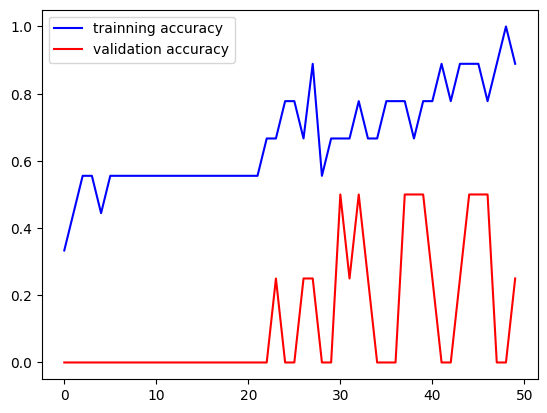

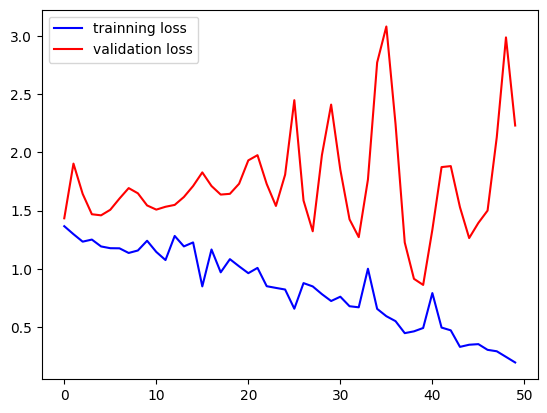

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, "b", label="trainning accuracy")
plt.plot(epochs, val_accuracy, "r", label="validation accuracy")
plt.legend()
plt.show()

plt.plot(epochs, loss, "b", label="trainning loss")
plt.plot(epochs, val_loss, "r", label="validation loss")
plt.legend()
plt.show()

# save model

In [ ]:
model.save("drowiness_new_1.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model.save("drowiness_new6_2.model")

# Prediction

In [ ]:
predict_x=model.predict(X_test)
prediction=np.argmax(predict_x,axis=1)

#prediction = model.predict_classes(X_test)

1/1 [==============================] - 0s 254ms/step


In [ ]:
prediction

array([2, 3, 2, 1])

# classification report

In [ ]:
labels_new = ["yawn", "no_yawn", "Closed", "Open"]

In [ ]:
from sklearn.metrics import classification_report


# predicting function

In [ ]:
labels_new = ["yawn", "no_yawn", "Closed", "Open"]
IMG_SIZE = 145
def prepare(filepath, face_cas="/content/drive/My Drive/Colab Notebooks/sleep/prediction-images/haarcascade_frontalface_default.xml"):
    img_array = cv2.imread(filepath, cv2.IMREAD_COLOR)
    img_array = img_array / 255
    resized_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
    return resized_array.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

model = tf.keras.models.load_model("./drowiness_new_1.h5")















63




















++++++-.369*02# Prediction
## 0-yawn, 1-no_yawn, 2-Closed, 3-Open

Objective: Prediction based on Psychological activities(Yawn,No_yawn) : 0,1

Objective : Drowsy detection : 2-closed

Objective : Validating reults with differant data



In [ ]:
# prepare("../input/drowsiness-dataset/train/no_yawn/1068.jpg")
prediction = model.predict([prepare("/content/drive/My Drive/Colab Notebooks/sleep/train/no_yawn/1006.jpg")])
np.argmax(prediction)

1/1 [==============================] - 0s 106ms/step


3

In [ ]:
prediction0 = model.predict([prepare("/content/drive/My Drive/Colab Notebooks/sleep/train/Closed/_1.jpg")])
np.argmax(prediction0)

1/1 [==============================] - 0s 56ms/step


2

In [ ]:
prediction1 = model.predict([prepare("/content/drive/My Drive/Colab Notebooks/sleep/train/Closed/_0.jpg")])
np.argmax(prediction1)

1/1 [==============================] - 0s 68ms/step


2

In [ ]:
prediction2 = model.predict([prepare("/content/drive/My Drive/Colab Notebooks/sleep/train/Open/_101.jpg")])
np.argmax(prediction2)

1/1 [==============================] - 0s 58ms/step


3

In [ ]:
prediction3 = model.predict([prepare("/content/drive/My Drive/Colab Notebooks/sleep/train/yawn/101.jpg")])
np.argmax(prediction3)

1/1 [==============================] - 0s 56ms/step


3

In [ ]:
print("Objective 3:  Steering wheel based drowsiness detection")

Objective 3:  Steering wheel based drowsiness detection


In [ ]:
dataset["target"].describe()

count    100.000000
mean       0.620000
std        0.487832
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: target, dtype: float64

In [ ]:
dataset.head()

vehicle_type  frequency_right_angle_movement  frequency_left_angle_movement  \
0          car                             200                            220   
1          bus                             190                            240   
2        truck                             150                            190   
3         Jeep                             190                            120   
4          car                             200                            150   

   frequency_steering_sudden_changes  target  
0                                  5       1  
1                                 10       1  
2                                  3       0  
3                                  4       0  
4                                  2       0

In [ ]:
dataset["target"].unique()

array([1, 0])

In [ ]:
from sklearn.model_selection import train_test_split

predictors = dataset.drop("vehicle_type",axis=1)

target = dataset["target"]

X_train,X_test,Y_train,Y_test = train_test_split(predictors,target,test_size=0.20,random_state=0)

In [ ]:
predictors
prediction_var=predictors

In [ ]:
X_train.shape

(80, 4)

In [ ]:
X_test.shape

(20, 4)

In [ ]:
Y_train.shape

(80,)

In [ ]:
Y_test.shape

(20,)

In [1]:
from sklearn.metrics import accuracy_score

In [ ]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()

lr.fit(X_train,Y_train)

Y_pred_lr = lr.predict(X_test)

In [ ]:
Y_pred_lr.shape

(20,)

In [ ]:
score_lr = round(accuracy_score(Y_pred_lr,Y_test)*100,2)

In [ ]:
print("The accuracy score is: "+str(score_lr)+" %")

The accuracy score achieved using Logistic Regression is: 100.0 %


In [6]:
#ML library
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics

#importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [7]:
train,test=train_test_split(dataset,test_size=0.3)
print(train.shape)
print(test.shape)

(70, 5)
(30, 5)


In [8]:
#prediction variables
prediction_var=['frequency_right_angle_movement','frequency_left_angle_movement','frequency_steering_sudden_changes']

In [9]:
prediction_var

['frequency_right_angle_movement',
 'frequency_left_angle_movement',
 'frequency_steering_sudden_changes']

In [10]:
#TRAINING DATA
#input training data for  steering wheel
train_X=train[prediction_var]
#output training data
train_Y=train['target']

In [11]:
#input training data for  steering wheel
train_X=train[prediction_var]
#output training data
train_Y1=train['frequency_right_angle_movement']

In [12]:
#input training data for  steering wheel
train_X=train[prediction_var]
#output training data
train_Z=train['frequency_left_angle_movement']

In [13]:
#TESTING DATA
#same steps for testing data
#input testing data for  steering wheel
test_X=test[prediction_var]
#output testing data
test_Y=test['target']

In [14]:
#same steps for testing data
#input testing data for  steering wheel
test_X=test[prediction_var]
#output testing data
test_Y1=test['frequency_right_angle_movement']

In [15]:
#same steps for testing data of  steering wheel
#input testing data  steering wheel
test_X=test[prediction_var]
#output testing data
test_Z=test['frequency_left_angle_movement']

In [18]:
#Training the model Status

model1=LogisticRegression()
model1.fit(train_X,train_Y)

LogisticRegression()

In [19]:
#Training the model for steering wheel

model_1=LogisticRegression()
model_1.fit(train_X,train_Z)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [20]:
#Training the model for  steering wheel

model_2=LogisticRegression()
model_2.fit(train_X,train_Y1)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [22]:
#Testing the algorithm  steering wheel
predicted_value=model1.predict(test_X)

In [23]:
#Testing the algorithm for  steering wheel
predicted_value_1=model_1.predict(test_X)

In [24]:
#Testing the algorithm for  steering wheel
predicted_value_2=model_2.predict(test_X)

In [25]:

#accuracy for  steering wheel
metrics.accuracy_score(test_Y1,predicted_value)
#prediction using  steering wheel
pd.DataFrame({'predicted_value':predicted_value_2,'KnowO/P of Stereing wheel Angles ':test_Y1})

predicted_value  KnowO/P of Stereing wheel Angles 
98              260                                260
34              260                                260
59              200                                200
17              190                                190
93              200                                200
91              200                                125
78              250                                250
18              250                                250
44              250                                200
20              250                                292
86              260                                260
31              123                                200
73              200                                206
64              250                                200
71              123                                200
3               256                                190
92              250                                250
48              250                                250
81              200                                200
27              190                                190
14              260                                260
85              200                                206
8               250                                250
16              200                                123
2               200                                150
40              200                                200
95              123                                200
76              200                                123
47              190                                190
57              190                                190

In [26]:
#prediction using steering wheel
print('1-Driver Sleepy, 0-Normal')
pd.DataFrame({'predicted_value':predicted_value,'Known O/P Whether Driver Drowsiness based on  steering wheel':test_Y})

1-Driver Sleepy, 0-Normal


predicted_value  \
98                1   
34                1   
59                1   
17                1   
93                1   
91                0   
78                1   
18                1   
44                0   
20                1   
86                1   
31                1   
73                1   
64                0   
71                1   
3                 0   
92                1   
48                1   
81                1   
27                1   
14                1   
85                1   
8                 1   
16                0   
2                 0   
40                1   
95                1   
76                0   
47                1   
57                1   

    Known O/P Whether Driver Drowsiness based on  steering wheel  
98                                                  1             
34                                                  1             
59                                                  1             
17                                                  1             
93                                                  1             
91                                                  0             
78                                                  1             
18                                                  1             
44                                                  0             
20                                                  1             
86                                                  1             
31                                                  1             
73                                                  1             
64                                                  0             
71                                                  1             
3                                                   0             
92                                                  1             
48                                                  1             
81                                                  1             
27                                                  1             
14                                                  1             
85                                                  1             
8                                                   1             
16                                                  0             
2                                                   0             
40                                                  1             
95                                                  1             
76                                                  0             
47                                                  1             
57                                                  1